In [1]:
from text_embedder import TextEmbedder
from gensim import corpora, models
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
import pickle
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from datetime import datetime
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE

In [2]:
# load pre-trained data
business = pd.read_csv('../data/chinese_business_clean.csv')
reviews = pd.read_csv('../data/chinese_reviews_clean.csv')

# load gensim model
lda =  models.LdaModel.load('../data/gensim/lda.model')
dictionary = corpora.Dictionary.load('../data/gensim/chinsese_dict.dict')

# load idf matrices
with open('../data/u_idf.pickle', 'rb') as f:
    uidf_data = pickle.load(f)
with open('../data/b_idf.pickle', 'rb') as f:
    bidf_data = pickle.load(f)

In [3]:
embedder = TextEmbedder(model = lda, dictionary = dictionary, user_idf = uidf_data, business_idf = bidf_data)

### Preprocess

In [4]:
# count the number of reviews per person
avg = reviews.groupby('user_id').mean().reset_index()[['user_id', 'stars']]
avg.to_csv('user_avg_star.csv', index=False)
avg.head()

,user_id,stars
0,---cu1hq55BP9DWVXXKHZg,1.0
1,--2HUmLkcNHZp0xw6AMBPg,5.0
2,--2vR0DIsmQ6WfcSzKWigw,4.0
3,--3oMd6gjXpAzhjLBrsVCQ,4.0
4,--4rAAfZnEIAKJE80aIiYg,1.0


In [5]:
# assign offset
look_up = {}
for u,avg in avg.values:
    look_up[u] = avg

In [6]:
# create a dataframe
offsets = []
for r, u, s in zip(reviews['review_id'].values, reviews['user_id'].values, reviews['stars'].values):
    offset = s - look_up[u]
    offsets.append({'review_id':r, 'offset':offset})

In [7]:
offset = pd.DataFrame(offsets)

In [8]:
print('Positive: {}'.format(len(offset[offset['offset'] > 0.0])))
print('Average : {}'.format(len(offset[offset['offset'] == 0.0])))
print('Negative: {}'.format(len(offset[offset['offset'] < 0.0])))

Positive: 42016
Average : 95692
Negative: 37644


In [9]:
# merge dataframe on user_id
reviews_offset = pd.merge(reviews, offset, on = 'review_id')

In [20]:
# save csv
reviews_offset.to_csv('chinese_reviews_clean_offsets.csv', index = False)

### Setup

In [13]:
# label data, try to predict simple labels -- positive(1), negative(-1) or average(0)
def labels(offsets):
    if offsets < 0.0:
        return -1
    else:
        return int(offsets > 0.0)

### Bin data monthly
TODO : Compare with binning by number (20?)

In [16]:
reviews_offset = reviews_offset.sort_values(by = 'date')

In [17]:
date_tuple = [datetime.strptime(d, '%Y-%m-%d') for d in reviews_offset['date']]
date_tuple = [(d.year, d.month) for d in date_tuple]

In [18]:
reviews_offset['date_tuple'] = date_tuple

In [19]:
monthly_count = reviews_offset.groupby('date_tuple').count().reset_index()[['review_id', 'date_tuple']]

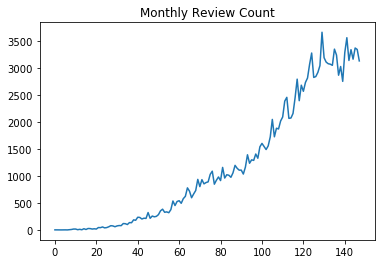

In [16]:
plt.plot(monthly_count['review_id'])
plt.title('Monthly Review Count')
plt.show()

In [21]:
# try basic methods with January of 2013 - 2017
def modified_split(df, year_month, embedder, t_size = 0.2, enum = 0, binary = False):
    # select regions
    data = df[df['date_tuple'] == year_month]
    if binary:
        data = data[data['offset'] != 0]
    # create labels
    label = data['offset'].values
    if enum == 0: 
        embed = np.array([embedder.augmented_embed_text(t) for t in data['text'].values])
    elif enum == 1: 
        embed = np.array([embedder.user_tfidf_embed(t, u) for t, u in zip(data['test'].values, data['user_id'].values)])
    elif enum == 2: 
        embed = np.array([embedder.user_tf_business_idf(t, b) for t in zip(data['test'].values, data['business_id'].values)])
    elif enum == 3: 
        embed = np.array([embedder.user_tfidf_business_idf(t, u, b) for t, u, b in zip(data['test'].values, data['user_id'].values, data['business_id'].values)])
    elif enum == 4: 
        embed = np.array([embedder.embed(t) for t in zip(data['test'].values)])
    elif enum == 5:
        embed = np.array([embedder.embed_sent(t) for t in zip(data['test'].values)])
    else:
        print ('enum {} is not supported'.format(enum))
        return None
    return embed, label

## Classification - Baseline

In [65]:
%time x_base, y_base = modified_split(reviews_offset, (2013, 1), embedder, 4)

CPU times: user 20.6 s, sys: 92.3 ms, total: 20.7 s
Wall time: 19.5 s


In [66]:
%time x_base_s, y_base_s = modified_split(reviews_offset, (2013, 1), embedder, 5)

CPU times: user 20.3 s, sys: 85.4 ms, total: 20.3 s
Wall time: 19.2 s


In [67]:
labels_v = np.vectorize(labels)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(x_base, y_base, test_size=0.2)

In [69]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, labels_v(y_train))
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.47610062893081762

In [70]:
classifier.score(X_test, labels_v(y_test))

0.37275985663082439

In [71]:
X_train, X_test, y_train, y_test = train_test_split(x_base_s, y_base_s, test_size=0.2)

In [72]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, labels_v(y_train))
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.46627756160830092

In [73]:
classifier.score(X_test, labels_v(y_test))

0.38351254480286739

## Classification - SVM

In [337]:
%time x0, y0 = modified_split(reviews_offset, (2013, 1), embedder, 0)

CPU times: user 19.6 s, sys: 69.7 ms, total: 19.7 s
Wall time: 18.8 s


In [302]:
%time x1, y1 = modified_split(reviews_offset, (2013, 1), embedder, 1)

CPU times: user 19.8 s, sys: 78 ms, total: 19.9 s
Wall time: 19 s


In [303]:
%time x2, y2 = modified_split(reviews_offset, (2013, 1), embedder, 2)

CPU times: user 20 s, sys: 107 ms, total: 20.1 s
Wall time: 19.3 s


In [53]:
%time x3, y3 = modified_split(reviews_offset, (2013, 1), embedder, 3)

CPU times: user 20 s, sys: 63.7 ms, total: 20 s
Wall time: 18.9 s


### Embedding 1

In [338]:
X_train, X_test, y_train, y_test = train_test_split(x0, y0, test_size=0.2)

In [339]:
sample_weight = abs(y_train)
labels_v = np.vectorize(labels)
y_train_l = labels_v(y_train)
classifier = SVC(kernel='rbf', class_weight = 'balanced', probability = True)
classifier.fit(X_train, y_train_l, sample_weight = sample_weight)
classifier.score(X_train, y_train_l)

0.26032315978456017

In [341]:
classifier.predict(X_test)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

#### Oversample

In [391]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train_l)
classifier = SVC(kernel='rbf', class_weight = 'balanced', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.46148738379814075

In [392]:
classifier.score(X_test, labels_v(y_test))

0.32258064516129031

In [393]:
# confusion matrix
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[15, 27, 25],
       [34, 48, 40],
       [30, 33, 27]])

### Embedding 2

In [349]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2)

In [350]:
sample_weight = abs(y_train)
y_train = labels_v(y_train)
classifier = SVC(kernel='rbf', class_weight = 'balanced', probability = True)
classifier.fit(X_train, y_train, sample_weight = sample_weight)
classifier.score(X_train, y_train)

0.26929982046678635

In [351]:
classifier.predict(X_test)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

#### Oversample

In [355]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.49146981627296588

In [357]:
classifier.score(X_test, labels_v(y_test))

0.35125448028673834

In [359]:
# confusion matrix
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[36,  5, 17],
       [74, 28, 31],
       [32, 22, 34]])

### Embedding 3

In [360]:
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2)

In [362]:
classifier = SVC(kernel='rbf', class_weight = 'balanced')
classifier.fit(X_train, labels_v(y_train))
classifier.score(X_train, labels_v(y_train))

0.27289048473967686

In [363]:
classifier.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

#### Oversample

In [365]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, labels_v(y_train))
classifier = SVC(kernel='rbf')
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.50674373795761074

In [366]:
classifier.score(X_test, labels_v(y_test))

0.35125448028673834

In [367]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[39,  5, 23],
       [58, 12, 52],
       [36,  7, 47]])

### Embedding 4

In [54]:
X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=0.2)

In [55]:
classifier = SVC(kernel='rbf', class_weight = 'balanced')
classifier.fit(X_train, labels_v(y_train))
classifier.score(X_train, labels_v(y_train))

0.2881508078994614

In [56]:
classifier.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

#### Oversample

In [58]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, labels_v(y_train))
classifier = SVC(kernel='rbf')
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.48228346456692911

In [59]:
classifier.score(X_test, labels_v(y_test))

0.37275985663082439

In [60]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[49,  8, 16],
       [72, 22, 39],
       [30, 10, 33]])

In [61]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, labels_v(y_train))
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.45734908136482938

In [62]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[56,  7, 10],
       [91, 12, 30],
       [39, 11, 23]])

In [64]:
classifier.score(X_test, labels_v(y_test))

0.32616487455197135

## Check Manifold

In [35]:
X_embedded = TSNE(n_components=2).fit_transform(x_base)

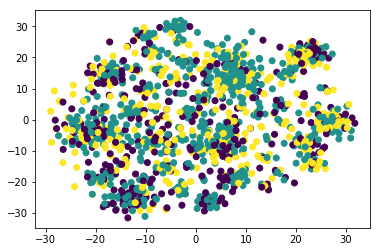

In [36]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = labels_v(y_base))
plt.show()

In [33]:
X_embedded = TSNE(n_components=2).fit_transform(x_base_b)

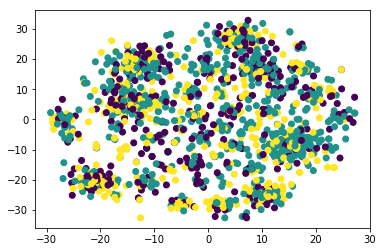

In [34]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = labels_v(y_base_b))
plt.show()

In [258]:
X_embedded = TSNE(n_components=2).fit_transform(x0)

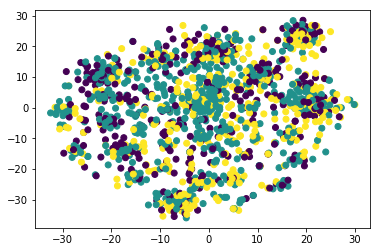

In [270]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y0)
plt.show()

In [271]:
X_embedded = TSNE(n_components=2).fit_transform(x1)

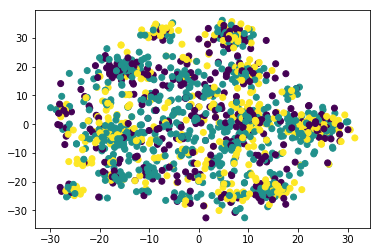

In [272]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y1)
plt.show()

In [273]:
X_embedded = TSNE(n_components=2).fit_transform(x2)

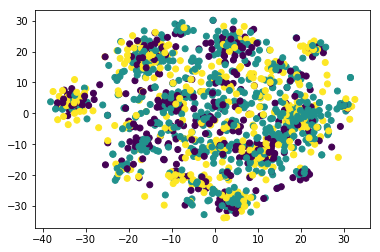

In [274]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y2)
plt.show()

In [275]:
X_embedded = TSNE(n_components=2).fit_transform(x3)

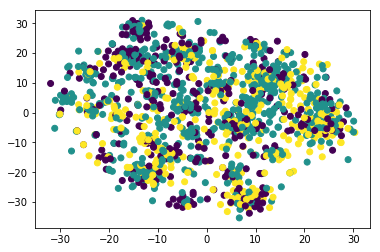

In [276]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y3)
plt.show()

## Repeat the process with only pos / neg

In [401]:
%time x0, y0 = modified_split(reviews_offset, (2013, 1), embedder, 0, binary = True)

CPU times: user 11.7 s, sys: 46.2 ms, total: 11.8 s
Wall time: 11.3 s


In [402]:
%time x1, y1 = modified_split(reviews_offset, (2013, 1), embedder, 1, binary = True)

CPU times: user 11.7 s, sys: 45.4 ms, total: 11.7 s
Wall time: 11.3 s


In [403]:
%time x2, y2 = modified_split(reviews_offset, (2013, 1), embedder, 2, binary = True)

CPU times: user 11.2 s, sys: 23.4 ms, total: 11.2 s
Wall time: 10.8 s


In [404]:
%time x3, y3 = modified_split(reviews_offset, (2013, 1), embedder, 3, binary = True)

CPU times: user 11.1 s, sys: 10.1 ms, total: 11.1 s
Wall time: 10.7 s


## Classification -Baseline 

In [38]:
%time x_base_b, y_base_b = modified_split(reviews_offset, (2013, 1), embedder, 4, binary = True)

CPU times: user 12 s, sys: 39.3 ms, total: 12.1 s
Wall time: 11.5 s


In [39]:
%time x_base_s_b, y_base_s_b = modified_split(reviews_offset, (2013, 1), embedder, 5, binary = True)

CPU times: user 11.9 s, sys: 44.8 ms, total: 12 s
Wall time: 11.4 s


In [42]:
X_train, X_test, y_train, y_test = train_test_split(x_base_b, y_base_b, test_size=0.2)

In [43]:
y_train = labels_v(y_train)
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.69206349206349205

In [44]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[41, 31],
       [26, 53]])

In [45]:
classifier.score(X_test, labels_v(y_test))

0.62251655629139069

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x_base_s_b, y_base_s_b, test_size=0.2)

In [48]:
y_train = labels_v(y_train)
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.67944785276073616

In [49]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[53, 30],
       [29, 39]])

In [50]:
classifier.score(X_test, labels_v(y_test))

0.60927152317880795

## Classification - SVM

### Embedding 1

In [450]:
X_train, X_test, y_train, y_test = train_test_split(x0, y0, test_size=0.2)

In [451]:
y_train = labels_v(y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_train, y_train)
classifier.score(X_train, y_train)

0.53410981697171378

In [452]:
classifier.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Oversample

In [453]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.70716510903426788

In [454]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[49, 29],
       [41, 32]])

In [455]:
classifier.score(X_test, labels_v(y_test))

0.53642384105960261

### Embedding 2

In [444]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2)

In [445]:
y_train = labels_v(y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_train, y_train)
classifier.score(X_train, y_train)

0.51747088186356072

In [446]:
classifier.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Oversample

In [447]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.67041800643086813

In [448]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[42, 26],
       [37, 46]])

In [449]:
classifier.score(X_test, labels_v(y_test))

0.58278145695364236

### Embedding 3

In [438]:
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2)

In [439]:
y_train = labels_v(y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_train, y_train)
classifier.score(X_train, y_train)

0.52745424292845255

In [440]:
classifier.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Oversample

In [441]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.6577287066246057

In [442]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[54, 20],
       [41, 36]])

In [443]:
classifier.score(X_test, labels_v(y_test))

0.59602649006622521

### Embedding 4

In [426]:
X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=0.2)

In [427]:
y_train = labels_v(y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_train, y_train)
classifier.score(X_train, y_train)

0.52745424292845255

In [428]:
classifier.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Oversample

In [433]:
ros = SMOTE()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
classifier = SVC(kernel='rbf', probability = True)
classifier.fit(X_resampled, y_resampled)
classifier.score(X_resampled, y_resampled)

0.65930599369085174

In [434]:
confusion_matrix(labels_v(y_test), classifier.predict(X_test))

array([[52, 22],
       [36, 41]])

In [436]:
classifier.score(X_test, labels_v(y_test))

0.61589403973509937

3 labels  

| Embedding     | Acuracy       | 
| ------------- | ------------- | 
| random guess  | 0.33          | 
| Embed         |  0.3727       |   
| Embed_sent    | **0.3835**       |
| Embed 1       | 0.3226        | 
| Embed 2       |  0.3513       |   
| Embed 3       | 0.3513        |
| Embed 4       | 0.3261        | 

2 labels  

| Embedding     | Acuracy       | 
| ------------- | ------------- | 
| random guess  | 0.50          | 
| Embed         |  **0.6225**       |   
| Embed_sent    | 0.6093    |
| Embed 1       | 0.5364        | 
| Embed 2       |  0.5828       |   
| Embed 3       | 0.5960        |
| Embed 4       | 0.6159        | 